## Analyse exploratoire série temporelle - fct_respiratory

In [14]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#read data 

fct_respiratory = pd.read_csv('fct_respiratory.csv')
dim_patient = pd.read_csv('dim_patient.csv')
dates = dim_patient[['id_patient','date_transplantation']]

#merge two dataframes per id_patient

df = pd.merge(fct_respiratory, dates, on='id_patient')
df['timestamp'] = df['date_transplantation'] + '-' +df['time']

#remove time = 0 

df = df[df['time'] != '0']

df['timestamp'] = pd.to_datetime(df['timestamp'])

In [5]:
df_melt = pd.melt(df, id_vars=['id_patient','timestamp'], value_vars=['etco2','eto2','fico2','fin2o','fr','fr_ecg','fio2','mac','peeptotal','pmax','pmean','pplat','rr_co2','spo2','svo2__m','vt'])

In [6]:
def plot_respiratory(id_patient):
    print 'Displaying respiratory measures for patient # {}'.format(id_patient)
    g = sns.FacetGrid(df_melt[df_melt['id_patient'] == id_patient], col="variable", col_wrap=4, sharey=False)
    g = g.map(plt.plot, "timestamp", "value")

Displaying respiratory measures for patient # 381


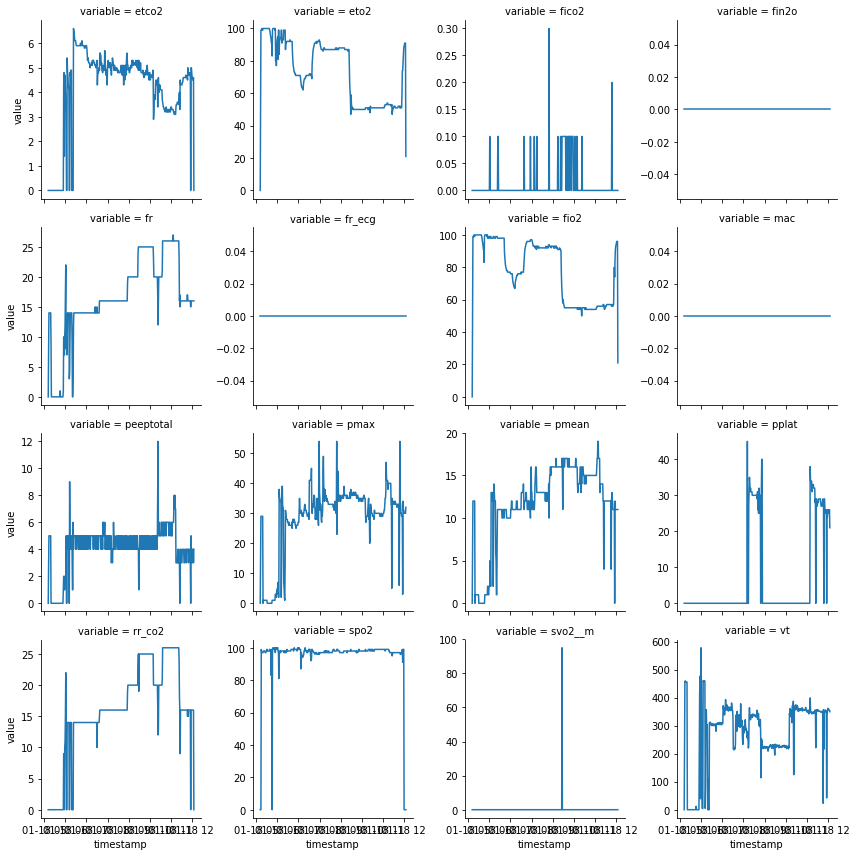

In [41]:
plot_respiratory(381)

In [8]:
dim_patient.columns

Index([u'id_patient', u'exclusion_plasmapherese', u'exclusion_pf',
       u'exclusion_ino', u'exclusion_lactate', u'date_transplantation',
       u'date_sortie_bloc', u'heure_arrivee_rea', u'age', u'sexe',
       u'body_mass_index', u'diabetes', u'preoperative_icu',
       u'preoperative_vasopressor', u'preoperative_mechanical_ventilation',
       u'super_urgence', u'time_on_waiting_liste',
       u'other_organ_transplantation', u'pathologie', u'retransplant',
       u'transplanted_twice_during_study_period', u'thoracic_surgery_history',
       u'preoperative_pulmonary_hypertension', u'plasmapherese', u'pfo',
       u'first_lung_ischemic_time', u'second_lung_ischemic_time', u'exvivo',
       u'preoperative_ecmo', u'postoperative_ecmo',
       u'only_intraoperative_ecmo', u'ecmo_during_surgery', u'ecmo_duration',
       u'cec', u'moment_de_pose_ecmo', u'cause_ecmo', u'pulmonary_reduction',
       u'adrenaline_perop', u'prdc', u'ffp', u'platelets', u'fluid_support',
       u'estimated_bl

In [9]:
dim_patient[['id_patient', 'immediate_extubation', 'secondary_intubation']]

,id_patient,immediate_extubation,secondary_intubation
0,1,0.0,0.0
1,2,1.0,0.0
2,3,0.0,0.0
3,4,0.0,0.0
4,5,0.0,0.0
5,6,1.0,0.0
6,7,0.0,0.0
7,8,0.0,0.0
8,9,0.0,0.0
9,10,0.0,0.0


Displaying respiratory measures for patient # 383


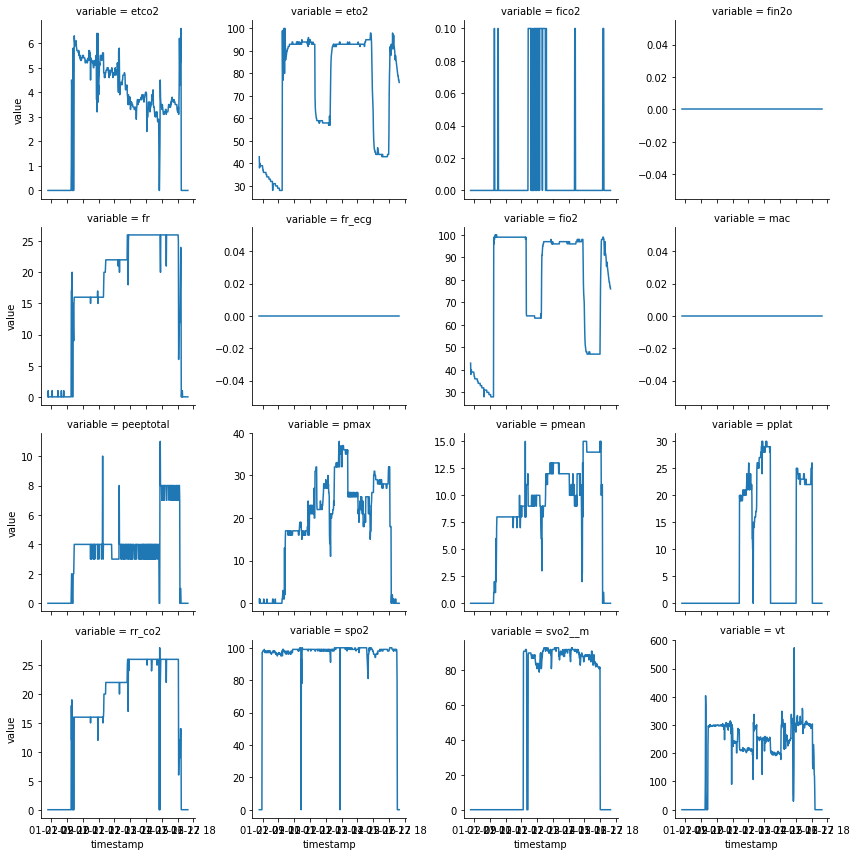

In [22]:
plot_respiratory(383)